In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import math
import re
from scipy.sparse import csr_matrix
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")
import os
import time
import gc
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [109]:
# Date not needed
# usecols means use certain columns by index
netflix_df2 = pd.read_csv('few_samples_netflix.csv')

netflix_df2['rating'] = netflix_df2['rating'].astype(float)

print('Dataset 2 shape: {}'.format(netflix_df2.shape))
print('-Dataset examples-')
print(netflix_df2.iloc[::50000, :])

netflix_df2.head(5)

Dataset 2 shape: (514358, 3)
-Dataset examples-
        movie_id  user_id  rating
0              1   729846     4.0
50000       1905   517358     3.0
100000      3713  2154387     3.0
150000      5345  2226039     3.0
200000      6930   798248     5.0
250000      8782  2093597     5.0
300000     10730  1415809     4.0
350000     12376  1962698     4.0
400000     14203  2004709     3.0
450000     15582   934318     5.0
500000     17295  1175759     2.0


,movie_id,user_id,rating
0,1,729846,4.0
1,1,915,5.0
2,1,1839976,2.0
3,1,1682651,4.0
4,1,1140108,4.0


In [160]:
# Lets see what we have here 
netflix_df2.describe()['rating']


count    323914.000000
mean          3.580173
std           1.050835
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [162]:
print("No of Nan values in our dataframe : ", sum(netflix_df2.isnull().any()))

No of Nan values in our dataframe :  0


In [165]:
dup_bool = netflix_df2.duplicated(['movie_id','user_id','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data.".format(dups))

There are 0 duplicate rating entries in the data.


In [166]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",netflix_df2.shape[0])
print("Total No of Users   :", len(np.unique(netflix_df2.user_id)))
print("Total No of movies  :", len(np.unique(netflix_df2.movie_id)))

Total data 
--------------------------------------------------

Total no of ratings : 323914
Total No of Users   : 584
Total No of movies  : 3596


In [168]:
#spliting whole data into train and test and storing it in train and test csv
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    netflix_df2.iloc[:int(netflix_df2.shape[0]*0.80)].to_csv("netflix_train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    netflix_df2.iloc[int(netflix_df2.shape[0]*0.80):].to_csv("netflix_test.csv", index=False)

train_df = pd.read_csv("netflix_train.csv")
test_df = pd.read_csv("netflix_test.csv")

In [170]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user_id)))
print("Total No of movies  :", len(np.unique(train_df.movie_id)))

Training data 
--------------------------------------------------

Total no of ratings : 259131
Total No of Users   : 584
Total No of movies  : 2914


In [171]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user_id)))
print("Total No of movies  :", len(np.unique(test_df.movie_id)))

Test data 
--------------------------------------------------

Total no of ratings : 64783
Total No of Users   : 584
Total No of movies  : 683


In [172]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

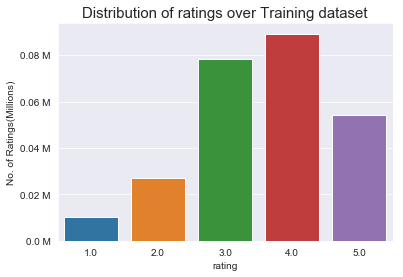

In [173]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

In [175]:
no_of_rated_movies_per_user = train_df.groupby(by='user_id')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user_id
1737529    1463
1486501    1425
760481     1354
974174     1291
1835511    1286
Name: rating, dtype: int64

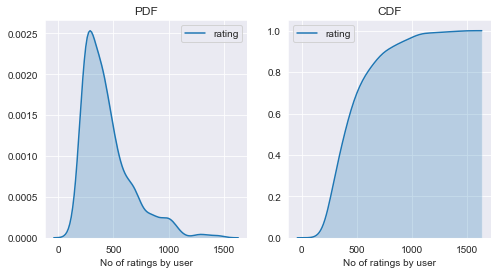

In [176]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [177]:
no_of_rated_movies_per_user.describe()

count     584.000000
mean      443.717466
std       221.871814
min       127.000000
25%       277.000000
50%       388.000000
75%       531.000000
max      1463.000000
Name: rating, dtype: float64

In [178]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

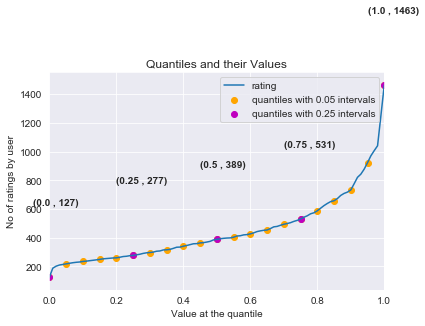

In [179]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

In [180]:
quantiles[::5]

0.00     127
0.05     218
0.10     235
0.15     249
0.20     260
0.25     277
0.30     297
0.35     316
0.40     341
0.45     364
0.50     389
0.55     404
0.60     427
0.65     454
0.70     494
0.75     531
0.80     588
0.85     658
0.90     733
0.95     923
1.00    1463
Name: rating, dtype: int64

In [181]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 923)) )


 No of ratings at last 5 percentile : 30



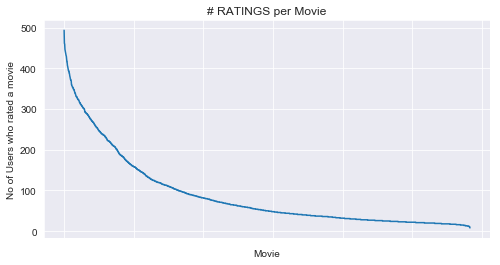

In [183]:


no_of_ratings_per_movie = train_df.groupby(by='movie_id')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

In [111]:
# play with quartile because it may affect model accuracy

count_mean_vars = ['count', 'mean']

movie_summary_df = netflix_df2.groupby('movie_id')['rating'].agg(count_mean_vars)
movie_summary_df.index = movie_summary_df.index.map(int)
movie_benchmark = round(movie_summary_df['count'].quantile(0.70), 0)
movie_list_benchmark_drop = movie_summary_df[movie_summary_df['count'] < movie_benchmark].index

print('Minimum number of times movies were reviewed: {}'.format(movie_benchmark))

customer_summary_df = netflix_df2.groupby('user_id')['rating'].agg(count_mean_vars)
customer_summary_df.index = customer_summary_df.index.map(int)
customer_benchmark = round(customer_summary_df['count'].quantile(0.70), 0)
customer_list_benchmark_drop = customer_summary_df[customer_summary_df['count'] < customer_benchmark].index

print('Minimum number of times customers reviewed movies: {}'.format(customer_benchmark))

Minimum number of times movies were reviewed: 21.0
Minimum number of times customers reviewed movies: 287.0


In [112]:
# Let's play with this and see how we can optimize it 
# Let's see the difference in data size
print('Original Shape: {}'.format(netflix_df2.shape))
netflix_df2 = netflix_df2[~netflix_df2['movie_id'].isin(movie_list_benchmark_drop)]
netflix_df2 = netflix_df2[~netflix_df2['user_id'].isin(customer_list_benchmark_drop)]
print('After Drop Shape: {}'.format(netflix_df2.shape))
print('---Data Examples---')
print(netflix_df2.iloc[::50000, :])

Original Shape: (514358, 3)
After Drop Shape: (323914, 3)
---Data Examples---
        movie_id  user_id  rating
28             8   304116     4.0
79950       3013  1036139     3.0
158637      5628   779765     3.0
237673      8327  2345678     5.0
316106     11209  2455561     3.0
396038     14056  1262307     4.0
476149     16460   509864     5.0


In [ ]:
netflix_df2_avg_rating = net

In [113]:
netflix_movie_titles_df5 = pd.read_csv('movie_titles.txt', delimiter='\t', header=None)
#netflix_movie_titles_df5.drop(['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis =1)
netflix_movie_titles_df5 = netflix_movie_titles_df5.iloc[:, 0:3]
netflix_movie_titles_df5.columns = ['Movie_id', 'Year', 'Movie_title']
netflix_movie_titles_df5['Year'] = netflix_movie_titles_df5['Year'] # data is dirty - has NaNs etc. - can't use int have to use float for now 
netflix_movie_titles_df5.head(5)

,Movie_id,Year,Movie_title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [114]:
#Collaborative filtering

# Import train_test_split function
from sklearn.model_selection import train_test_split

# Assign X as the original ratings dataframe and y as the Cust_id column of ratings
X = netflix_df2.copy()
y = netflix_df2['user_id']

# Split into training and test datasets, stratified along Cust-id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Import the mean_squared_error function
from sklearn.metrics import mean_squared_error

# Function computes the root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define the base model to always return 3 - middle of the ratings
def baseline(user_id, movie_id):
    return 3.0

# Function to compute the RMSE score obtained on the testing data set by the model
def score(collab_filter_model):
    
    # Construct a list of customer-movie tuples from the testing dataset
    id_cust_movie = zip(X_test['user_id'], X_test['movie_id'])
    
    # Predict the rating for every customer - movie tuple
    y_pred = np.array([collab_filter_model(customer, movie) for (customer, movie)in id_cust_movie])
    
    # Extract the actual ratings given by the customers in the test dataset
    y_true = np.array(X_test['rating'])
    
    # Return the final RMSE score
    return rmse(y_true, y_pred)

In [115]:
score(baseline)

1.2011738044522133

In [116]:
# Ratings Matrix
# Build the ratings matrix using the pivot_table functionality
ratings_matrix = X_train.pivot_table(values='rating', index='user_id', columns='movie_id')

ratings_matrix.head(5)

movie_id,8,17,18,28,30,33,44,46,52,58,...,17724,17725,17730,17743,17756,17758,17761,17762,17764,17769
user_id,,,,,,,,,,,,,,,,,,,,,
22994,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
28436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
28779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
41546,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
44434,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0,1.0,NaN


In [117]:
# Set the null / NaN ratings in the mean_ratings matrix to zero
mean_ratings = ratings_matrix.copy().fillna(0)
mean_ratings_sparse = csr_matrix(mean_ratings.values)
mean_ratings = mean_ratings_sparse

In [118]:
#Mean

# Customer based collaborative filtering using mean ratings
def collab_filter_mean(user_id, movie_id):
    
    
    # Check to see if Movie_id exists in ratings_matrix
    if movie_id in ratings_matrix:
        
        # Compute the mean of all the ratings given to the movie by the customers
        mean_ratings = ratings_matrix[movie_id].mean()
        
    else:
        
        # Default to a rating of 3.0 in the absense of any information
        mean_ratings = 3.0
        
    return mean_ratings    

In [119]:
# runs slow

# Compute RMSE for the Mean model
score(collab_filter_mean)

0.9871991770245973

In [120]:
# Weighted Mean
# Create a dummy ratings matrix with all null values imputed to 0
ratings_matrix_dummy = ratings_matrix.copy().fillna(0)

ratings_matrix_dummy.head(5)


movie_id,8,17,18,28,30,33,44,46,52,58,...,17724,17725,17730,17743,17756,17758,17761,17762,17764,17769
user_id,,,,,,,,,,,,,,,,,,,,,
22994,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
28779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
41546,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
44434,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0


In [121]:
# Import cosine_score
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix using the dummy ratings matrix
cosine_similar = cosine_similarity(ratings_matrix_dummy, ratings_matrix_dummy)

In [126]:
# Convert into pandas dataframe
cosine_similar = pd.DataFrame(cosine_similar, index=ratings_matrix.index, columns=ratings_matrix.index)

cosine_similar.head(5)



user_id,22994,28436,28779,41546,44434,48536,49718,51870,56108,59510,...,2576011,2591961,2595332,2597760,2597934,2602754,2614179,2620721,2629996,2638144
user_id,,,,,,,,,,,,,,,,,,,,,
22994,1.000000,0.222630,0.134790,0.233561,0.294244,0.167573,0.162004,0.241013,0.213797,0.237768,...,0.098786,0.181219,0.164264,0.077158,0.233606,0.110004,0.239241,0.250008,0.172844,0.191529
28436,0.222630,1.000000,0.158524,0.297552,0.310977,0.246239,0.146194,0.310102,0.245716,0.300433,...,0.103443,0.227346,0.153906,0.119913,0.248686,0.189748,0.287697,0.297404,0.230567,0.089956
28779,0.134790,0.158524,1.000000,0.179835,0.173221,0.105653,0.084749,0.139128,0.157506,0.148041,...,0.154399,0.145565,0.156071,0.162247,0.209208,0.081744,0.159877,0.132755,0.254545,0.201470
41546,0.233561,0.297552,0.179835,1.000000,0.261113,0.173640,0.171009,0.275884,0.170581,0.257021,...,0.152093,0.257170,0.197381,0.172524,0.226058,0.114353,0.233103,0.315217,0.265931,0.121817
44434,0.294244,0.310977,0.173221,0.261113,1.000000,0.265784,0.266647,0.368064,0.355865,0.307816,...,0.173937,0.208807,0.225525,0.127962,0.380775,0.153244,0.472590,0.305872,0.312487,0.212442


In [192]:
export_csv = cosine_similar.to_csv (r'C:\Users\AaronDataScienceComp\Documents\export_cosine_similar.csv', index = None, header=True)

export_csv

In [123]:
#U# User based collaborative filtering using weighted mean ratings
def collab_filter_cust_wmean(user_id, movie_id):
    
    # Check to see if Movie_id exists in ratings_matrix
    if movie_id in ratings_matrix:
        
        # Pull similarity scores for the customer in question with every other customer
        similar_scores = cosine_similar[user_id]
        
        # Pull the customer ratings for the movie in question
        movie_ratings = ratings_matrix[movie_id]
        
        # Extract the indices containing NaN in the moving_ratings series
        idx = movie_ratings[movie_ratings.isnull()].index
        
        # Drop the NaN values from the movie_ratings
        movie_ratings = movie_ratings.dropna()
        
        # Drop the corresponding cosine scores from the similar_scores series
        similar_scores = similar_scores.drop(idx)
        
        # Compute the final weighted mean
        wmean_rating = np.dot(similar_scores, movie_ratings) / similar_scores.sum()
        
    else:
        
        # Default to a rating of 3.0 which is the middle of ratings in the absence of any other information
        
        wmean_rating = 3.0
    
    return wmean_rating 

In [124]:
score(collab_filter_cust_wmean)

0.9771859712138505

In [ ]:
# Hybrid Recommender

In [ ]:
import numpy as np
import pandas as pd

In [130]:
cosine_similar.head(5)

# Or we can import it from the .csv I created

user_id,22994,28436,28779,41546,44434,48536,49718,51870,56108,59510,...,2576011,2591961,2595332,2597760,2597934,2602754,2614179,2620721,2629996,2638144
user_id,,,,,,,,,,,,,,,,,,,,,
22994,1.000000,0.222630,0.134790,0.233561,0.294244,0.167573,0.162004,0.241013,0.213797,0.237768,...,0.098786,0.181219,0.164264,0.077158,0.233606,0.110004,0.239241,0.250008,0.172844,0.191529
28436,0.222630,1.000000,0.158524,0.297552,0.310977,0.246239,0.146194,0.310102,0.245716,0.300433,...,0.103443,0.227346,0.153906,0.119913,0.248686,0.189748,0.287697,0.297404,0.230567,0.089956
28779,0.134790,0.158524,1.000000,0.179835,0.173221,0.105653,0.084749,0.139128,0.157506,0.148041,...,0.154399,0.145565,0.156071,0.162247,0.209208,0.081744,0.159877,0.132755,0.254545,0.201470
41546,0.233561,0.297552,0.179835,1.000000,0.261113,0.173640,0.171009,0.275884,0.170581,0.257021,...,0.152093,0.257170,0.197381,0.172524,0.226058,0.114353,0.233103,0.315217,0.265931,0.121817
44434,0.294244,0.310977,0.173221,0.261113,1.000000,0.265784,0.266647,0.368064,0.355865,0.307816,...,0.173937,0.208807,0.225525,0.127962,0.380775,0.153244,0.472590,0.305872,0.312487,0.212442


In [147]:
ratings_matrix_dummy.head(5)

movie_id,8,17,18,28,30,33,44,46,52,58,...,17724,17725,17730,17743,17756,17758,17761,17762,17764,17769
user_id,,,,,,,,,,,,,,,,,,,,,
22994,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
28779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
41546,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
44434,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0


In [140]:
netflix_movie_titles_df5 = pd.read_csv('movie_titles.txt', delimiter='\t', header=None)
#netflix_movie_titles_df5.drop(['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis =1)
netflix_movie_titles_df5 = netflix_movie_titles_df5.iloc[:, 0:3]
netflix_movie_titles_df5.columns = ['movie_id', 'year', 'movie_title']
netflix_movie_titles_df5['year'] = netflix_movie_titles_df5['year'] # data is dirty - has NaNs etc. - can't use int have to use float for now 
netflix_movie_titles_df5.head(5)

,movie_id,year,movie_title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [189]:
netflix_df2.head(5)

,movie_id,user_id,rating
28,8,304116,4.0
29,8,1682908,5.0
32,8,1693596,1.0
35,8,1346269,1.0
36,8,1335524,4.0


In [190]:
data = pd.merge(netflix_df2, netflix_movie_titles_df5, on='movie_id')
data.head(5)

,movie_id,user_id,rating,year,movie_title
0,8,304116,4.0,2004.0,What the #$*! Do We Know!?
1,8,1682908,5.0,2004.0,What the #$*! Do We Know!?
2,8,1693596,1.0,2004.0,What the #$*! Do We Know!?
3,8,1346269,1.0,2004.0,What the #$*! Do We Know!?
4,8,1335524,4.0,2004.0,What the #$*! Do We Know!?


In [191]:
export_csv_movie = data.to_csv (r'C:\Users\AaronDataScienceComp\Documents\export_data_netflix_movies.csv', index = None, header=True)

export_csv_movie